This example shows how to reuse weights that have been learned with online learning for use in another networks. It assumes that you've already gone through and understood the [heteroassociative memory learning example](https://pythonhosted.org/nengo/examples/learn_associations.html).

In [1]:
copyright = "Copyright (c) 2016 Applied Brain Research Inc."
license = "Creative Commons Zero (public domain) https://creativecommons.org/publicdomain/zero/1.0/"

First create the network as shown in the aforementioned heteroassociative memory example.

In [1]:
import numpy as np

import nengo

num_items = 5

d_key = 2
d_value = 4
SEED = 7

rng = np.random.RandomState(seed=SEED)
keys = nengo.dists.UniformHypersphere(surface=True).sample(num_items, d_key, rng=rng)
values = nengo.dists.UniformHypersphere(surface=False).sample(num_items, d_value, rng=rng)

intercept = (np.dot(keys, keys.T) - np.eye(num_items)).flatten().max()


def cycle_array(x, period, dt=0.001):
    """Cycles through the elements"""
    i_every = int(round(period/dt))
    if i_every != period/dt:
        raise ValueError("dt (%s) does not divide period (%s)" % (dt, period))
    def f(t):
        i = int(round((t - dt) / dt))  # t starts at dt
        idx = (i // i_every) % len(x)
        return x[idx]
    return f

# Model constants
n_neurons = 200
dt = 0.001
period = 0.3
T = period * num_items
sample_every = 0.01


with nengo.Network() as train_model:
    
    # Create the inputs/outputs
    stim_keys = nengo.Node(cycle_array(keys, period, dt))
    stim_values = nengo.Node(cycle_array(values, period, dt))
    # Turn learning permanently on
    learning = nengo.Node([0])
    recall = nengo.Node(size_in=d_value)
    
    # Create the memory with a seed, so we can create the same ensemble again
    # in the new network
    memory = nengo.Ensemble(n_neurons, d_key, intercepts=[intercept]*n_neurons,
                           seed=SEED)
    
    # Learn the encoders/keys
    voja = nengo.Voja(post_tau=None, learning_rate=5e-2)
    conn_in = nengo.Connection(stim_keys, memory, synapse=None,
                               learning_rule_type=voja)
    nengo.Connection(learning, conn_in.learning_rule, synapse=None)
    
    # Learn the decoders/values, initialized to a null function
    conn_out = nengo.Connection(memory, recall,
                                learning_rule_type=nengo.PES(1e-3),
                                function=lambda x: np.zeros(d_value))
    
    # Create the error population
    error = nengo.Ensemble(n_neurons, d_value)
    nengo.Connection(learning, error.neurons, transform=[[10.0]]*n_neurons,
                     synapse=None)
    
    # Calculate the error and use it to drive the PES rule
    nengo.Connection(stim_values, error, transform=-1, synapse=None)
    nengo.Connection(recall, error, synapse=None)
    nengo.Connection(error, conn_out.learning_rule)

Instead of probing the usual outputs of the network, we're going to probe the weights so we can transfer them to our new network. We could still probe the input and outputs to verify the network is functioning, but for now, we're just going to assume it works.

In [5]:
with train_model:
    # Setup probes to save the weights
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=sample_every)
    p_enc = nengo.Probe(memory, 'scaled_encoders',
                        sample_every=sample_every)

In [6]:
# run the model and retrieve the encoders and decoders
with nengo.Simulator(train_model, dt=dt) as train_sim:
    train_sim.run(T)

enc = train_sim.data[p_enc][-1]
dec = train_sim.data[p_dec][-1]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


We'll now insert the encoders and decoders we gathered into our new network and verify that our network works the same as the old one. One important thing to note is that we `seed` parameter of the `memory` the same way as the last network to make sure we're dealing with the same neurons.

In [7]:
with nengo.Network() as test_model:
    
    # Create the inputs/outputs
    stim_keys = nengo.Node(cycle_array(keys, period, dt))
    stim_values = nengo.Node(cycle_array(values, period, dt))
    # Turn learning off to show that our network still works
    learning = nengo.Node([-1])
    recall = nengo.Node(size_in=d_value)

    # Create the memory with the new encoders
    memory = nengo.Ensemble(n_neurons, d_key, intercepts=[intercept]*n_neurons,
                            encoders=enc, n_eval_points=0, seed=SEED)
    
    nengo.Connection(stim_keys, memory, synapse=None,)
    
    # Create the connection out with the new decoders
    conn_out = nengo.Connection(memory.neurons, recall, transform=dec)
    
    # Setup probes
    p_val = nengo.Probe(stim_values, synapse=0.005)
    p_recall = nengo.Probe(recall, synapse=0.005)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


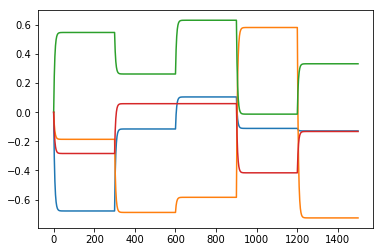

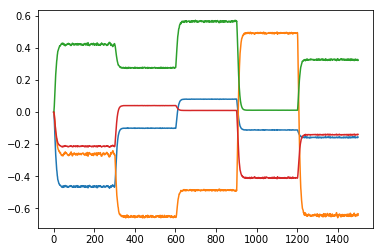

In [8]:
# run the network and plot the results for verification
with nengo.Simulator(test_model, dt=dt) as test_sim:
    test_sim.run(T)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(test_sim.trange(), test_sim.data[p_val])
plt.title("Expected")
plt.figure()

plt.plot(test_sim.trange(), test_sim.data[p_recall])
plt.show()

The values output by our memory match our expected values. Our connection weight transfer worked!